In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.style.use('ggplot')

In [4]:
GSPC = yf.download("^GSPC", start="1999-04-01", end="2019-10-09", interval = "1d")
VIX = yf.download("^VIX", start="1999-04-01", end="2019-10-09", interval = "1d")

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [5]:
GSPC_Close = GSPC[['Close']].values.astype(float)
VIX_Close = VIX[['Close']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
GSPC_scaled = min_max_scaler.fit_transform(GSPC_Close)
VIX_scaled = min_max_scaler.fit_transform(VIX_Close)

In [6]:
clean_data = pd.DataFrame(index=GSPC.index, data=GSPC_scaled, columns=['S&P500'])
clean_data['VIX'] = VIX_scaled

## Analyzed Periods

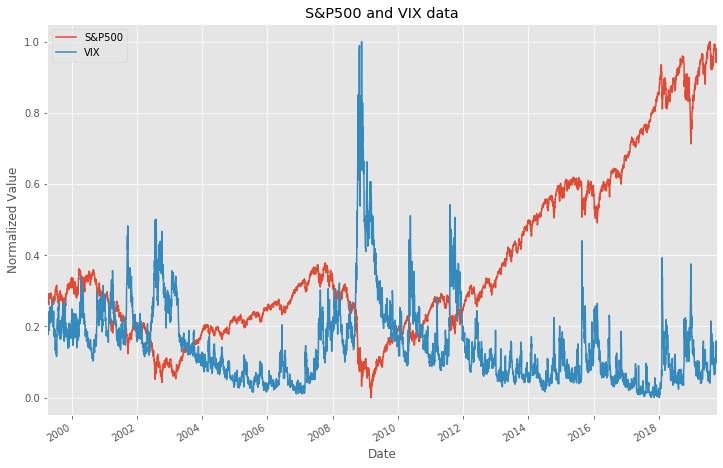

In [7]:
# Closing value of the S&P500 and VIX.
ax = clean_data.plot(figsize=(12,8), title = 'S&P500 and VIX data')
_ = ax.set_ylabel("Normalized Value")

In [97]:
train_GSPC_up = GSPC.loc['20030214':'20071009']
train_GSPC_down = GSPC.loc['20000901':'20030213']
test_GSPC_up = GSPC.loc['20090409':'20100326']
test_GSPC_down = GSPC.loc['20071009':'20080926']

train_VIX_up = VIX.loc['20030214':'20071009']
train_VIX_down = VIX.loc['20000901':'20030213']
test_VIX_up = VIX.loc['20090409':'20100326']
test_VIX_down = VIX.loc['20071009':'20080926']

## Quantitative Algorithms

In [98]:
def RSI(df, column="Close", period=14):
    # Wilder's RSI
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rUp = up.ewm(com=period - 1, adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()
    rsi = 100 - 100 / (1 + rUp / rDown)
    df = df.join(rsi.to_frame('RSI'))
    df['RSI_p1'] = df['RSI'].shift()
    df['RSI_p2'] = df['RSI_p1'].shift()
    return df

In [99]:
def MACD(df, column="Close", fast=12, slow=26, line=9):
    exp1 = df[column].ewm(span=fast, adjust=False).mean()
    exp2 = df[column].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=9, adjust=False).mean()
    df = df.join(macd.to_frame('MACD'))
    df['MACD_p1'] = df['MACD'].shift()
    df['MACD_p2'] = df['MACD_p1'].shift()
    return df

In [100]:
def ml_input(df, trend='up', types='train'):
    df1 = RSI(df)[['RSI', 'RSI_p1', 'RSI_p2']]
    df2 = MACD(df)[['MACD', 'MACD_p1', 'MACD_p2']]
    if trend=='up' and types =='train':
        df3 = train_VIX_up['Close']
    if trend=='down' and types =='train':
        df3 = train_VIX_down['Close']
    if trend=='up' and types =='test':
        df3 = test_VIX_up['Close']
    if trend=='down' and types =='test':
        df3 = test_VIX_down['Close']
    df1 = df1.join(df2)
    df1 = df1.join(df3)
    df1.rename(columns={"Close": "VIX"},inplace=True)
    df1['VIX_p1'] = df1['VIX'].shift()
    df1['VIX_p2'] = df1['VIX_p1'].shift()
    df1['S&P_change'] = df['Close'].diff()
    
    df1.drop(index=df1.index[:26], inplace=True)
    df1.drop(index=df1.index[-5:], inplace=True)

    return df1

In [101]:
def ml_output(data, shift_forward=5):
    df = data.copy()
    diff = (df['Close'].shift(-shift_forward) - df['Close'])
    df['Trading Signal'] = -1
    df.loc[diff>=0, 'Trading Signal'] = 1
    
    df.drop(index=df.index[:26], inplace=True)
    df.drop(index=df.index[-5:], inplace=True)
    
    return df[['Trading Signal']]

## Data

In [102]:
X_train_up = ml_input(train_GSPC_up)
y_train_up = ml_output(train_GSPC_up)

In [103]:
X_train_up

RSI     RSI_p1     RSI_p2       MACD    MACD_p1    MACD_p2  \
Date                                                                           
2003-03-25  67.310957  65.310443  78.748306  11.393296  10.680203  10.684797   
2003-03-26  65.458175  67.310957  65.310443  11.440041  11.393296  10.680203   
2003-03-27  64.883978  65.458175  67.310957  11.232220  11.440041  11.393296   
2003-03-28  62.801318  64.883978  65.458175  10.540939  11.232220  11.440041   
2003-03-31  56.808465  62.801318  64.883978   8.657104  10.540939  11.232220   
...               ...        ...        ...        ...        ...        ...   
2007-09-26  61.000745  59.009593  59.187319  14.801122  14.028239  13.673639   
2007-09-27  62.427597  61.000745  59.009593  15.713425  14.801122  14.028239   
2007-09-28  60.573532  62.427597  61.000745  15.879777  15.713425  14.801122   
2007-10-01  65.420331  60.573532  62.427597  17.447720  15.879777  15.713425   
2007-10-02  65.245786  65.420331  60.573532  18.444623  17.447720  15.879777   

              VIX  VIX_p1  VIX_p2  S&P_change  
Date                                           
2003-03-25  28.75   30.39   28.67       10.51  
2003-03-26  28.23   28.75   30.39       -4.79  
2003-03-27  27.96   28.23   28.75       -1.43  
2003-03-28  27.75   27.96   28.23       -5.02  
2003-03-31  29.15   27.75   27.96      -15.32  
...           ...     ...     ...         ...  
2007-09-26  17.63   18.60   19.37        8.21  
2007-09-27  17.00   17.63   18.60        5.96  
2007-09-28  18.00   17.00   17.63       -4.63  
2007-10-01  17.84   18.00   17.00       20.29  
2007-10-02  18.49   17.84   18.00       -0.41  

[1140 rows x 10 columns]

In [104]:
X_train_up.shape

(1140, 10)

In [105]:
y_train_up

Trading Signal
Date                      
2003-03-25              -1
2003-03-26               1
2003-03-27               1
2003-03-28               1
2003-03-31               1
...                    ...
2007-09-26               1
2007-09-27               1
2007-09-28               1
2007-10-01               1
2007-10-02               1

[1140 rows x 1 columns]

In [106]:
y_train_up.shape

(1140, 1)

## Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
n_trees = 100

rf = RandomForestClassifier(n_estimators=n_trees, max_depth=3, random_state=42)

In [109]:
rf.fit(X_train_up.values, y_train_up.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [110]:
prob = rf.predict_proba(X_train_up.values)

In [111]:
rf.classes_

array([-1,  1])

In [112]:
purchase_TH = 0.55
sale_TH = 0.30

In [113]:
X_train_up_pred = rf.predict(X_train_up.values)

In [114]:
X_test_up = ml_input(test_GSPC_up, types='test')
y_test_up = ml_output(test_GSPC_up)

In [115]:
X_test_up_pred_rf = rf.predict(X_test_up.values)

## SVM

In [116]:
from sklearn.svm import SVC

In [529]:
kernel = 'rbf'
C = 100
gamma = 0.0001

svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True)

In [530]:
# svm.fit(X_train_up.values, y_train_up.values.ravel())

In [531]:
# svm.predict_proba(X_train_up.values)

In [532]:
# svm.classes_

In [533]:
# X_train_up_pred = svm.predict(X_train_up.values)

In [534]:
# X_test_up_pred_svm = svm.predict(X_test_up.values)

In [535]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
#gmm = GaussianMixture(n_components=2).fit(X_train_up.values)
kmeans = KMeans(n_clusters=6).fit(X_train_up.values)
distances = np.column_stack([np.sum((X_train_up.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])
#proba = gmm.predict_proba(X_train_up.values)

In [536]:
svm.fit(distances, y_train_up.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [537]:
kmeans = KMeans(n_clusters=6).fit(X_test_up.values)
distances = np.column_stack([np.sum((X_test_up.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [538]:
#proba = gmm.predict_proba(X_test_up.values)

In [539]:
X_test_up_pred_svm = svm.predict(distances)

## Backtester

In [540]:
def backtester(prices, orders, trend='up', initial_cap=10000, commission=0.0035):
    position = 0
    shares = 0
    capital = initial_cap
    capital_list = []
    
    if trend == 'up':

        for order, price in zip(orders, prices):

            if order == 1 and position == 0:
                position = 1
                capital = capital * (1 - commission)
                shares = capital / price[0]

            elif order == 1 and position == 1:
                capital = shares * price[1]

            elif order == -1 and position == 1:
                position = 0
                capital = shares * price[1] * (1 - commission)
                shares = 0

            elif order == -1 and position == 0:
                capital = capital

            capital_list.append(capital)
    
    if trend == 'down':

        for order, price in zip(orders, prices):

            if order == -1 and position == 0:
                position = -1
                shares = capital / price[0]
                stock_values = shares * price[0] * (1 - commission)
                capital = capital + stock_values - shares * price[0]

            elif order == -1 and position == -1:
                stocks_value = shares * price[1]
                capital = capital + stock_values - shares * price[1]

            elif order == 1 and position == -1:
                position = 0
                stock_values = shares * price[1] * (1 - commission)
                capital = capital + stock_values - shares * price[1]
                shares = 0

            elif order == 1 and position == 0:
                capital = capital

            capital_list.append(capital)
    
    return capital_list

In [541]:
prices = test_GSPC_up[['Open', 'Close']]
prices.drop(index=prices.index[:26], inplace=True)
prices.drop(index=prices.index[-5:], inplace=True)

/Users/victor/anaconda3/envs/py37tf2/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [542]:
rf_orders = X_test_up_pred_rf
svm_orders = X_test_up_pred_svm

In [543]:
rf_capitals = backtester(prices.values, rf_orders, trend='up')
svm_capitals = backtester(prices.values, svm_orders, trend='up')

In [544]:
BH_capitals = backtester(prices.values, np.ones(orders.shape), trend='up')

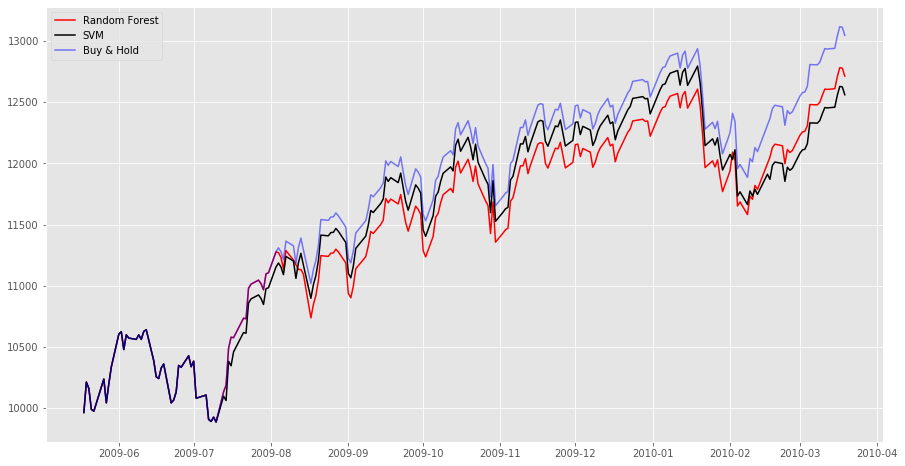

In [545]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(prices.index, rf_capitals, label='Random Forest', color='r')
_ = plt.plot(prices.index, svm_capitals, label='SVM', color='k')
_ = plt.plot(prices.index, BH_capitals, label='Buy & Hold', color='b', alpha=0.5)
_ = plt.legend()

In [474]:
svm_orders.all()

True

In [131]:
daily_capitals = pd.DataFrame(capitals, columns=['capitals'])

In [50]:
daily_returns = daily_capitals.pct_change()

In [55]:
pow((1 + (capitals[-1] - 10000)/10000), 252/len(capitals))

1.082105999562651

In [ ]:
initial_cap = 10000
commission = 0.0035

In [ ]:
position = 0
shares = 0
capital = initial_cap
capital_list = []

for order, price in zip(orders, prices):
    
    if order == 1 and position == 0:
        position = 1
        capital = capital * (1 - commission)
        shares = capital / price[0]
    
    elif order == 1 and position == 1:
        capital = shares * price[1]
        
    elif order == -1 and position == 1:
        position = 0
        capital = shares * price[1] * (1 - commission)
        shares = 0
  
    elif order == -1 and position == 0:
        capital = capital
    
    capital_list.append(capital)

In [ ]:
capital

In [ ]:
position = 0
shares = 0
capital = initial_cap
capital_list = []

for order, price in zip(orders, prices):
    
    if order == -1 and position == 0:
        position = -1
        shares = capital / price[0]
        stock_values = shares * price[0] * (1 - commission)
        capital = capital + stock_values - shares * price[0]
    
    elif order == -1 and position == -1:
        stocks_value = shares * price[1]
        capital = capital + stock_values - shares * price[1]
        
    elif order == 1 and position == -1:
        position = 0
        stock_values = shares * price[1] * (1 - commission)
        capital = capital + stock_values - shares * price[1]
        shares = 0
  
    elif order == 1 and position == 0:
        capital = capital
    
    capital_list.append(capital)

In [ ]:
capital

In [ ]:
plt.plot(capital_list)